In [2]:
import pandas as pd
import numpy as np
import itertools

In [3]:
def getWorldSpace(wall, nBoxes, nRewards): #omega world, list output
    if wall:
        possibleWorlds = [w for w in itertools.product([1,0], repeat = nBoxes)] 
    else:
        possibleWorlds = [w for w in itertools.product([1,0], repeat = nBoxes) if list(w).count(1) == nRewards]
    return(possibleWorlds)

def getActionSpace(nBoxes, nReceiverChoices): #omega actions, list output
    possibleActions = [a for a in itertools.product([1,0], repeat = nBoxes) 
                       if sum(a) <= nReceiverChoices]
    return(possibleActions)

def getSignalSpace(nBoxes, nSignals): #omega singals, list output
    all_utterances = [c for c in itertools.product([1,0], repeat = nBoxes) 
                      if (sum(c) <= nSignals)] 
    return(all_utterances)

# Misyak - returns a boolean of whether the input signal is possible given the mind and signal category
def signalIsConsistent_Boxes(signal, mind, signalType, goToSignal = '1'):
    world = mind['worlds']
    signalTypeStr = str(signalType)
    
    if signalTypeStr == goToSignal:
        consistentSignals = [int(w == 1) for u, w in zip(signal, world) if u == 1]  
    else:
        consistentSignals = [int(w != 1) for u, w in zip(signal, world) if u == 1]
    return(consistentSignals.count(0) == 0)

In [1]:
#mind generation (pdf over set of possible target minds)- specify each mind component function and combine for the full mind distribution
class GenerateMind(object):
    def __init__(self, getWorldProbability, getDesireProbability, getGoalProbability):
        self.getWorldProbability = getWorldProbability
        self.getDesireProbability = getDesireProbability
        self.getGoalProbability = getGoalProbability
        self.mindProbabilityLabel = 'p(mind)'
        
    def __call__(self, mindSpaceDictionary):
        jointMindSpace = getMultiIndexMindSpace(mindSpaceDictionary)
        getMindForCondition = lambda x: self.getConditionMind(x, mindSpaceDictionary)
        mindProbabilitySeries = jointMindSpace.groupby(jointMindSpace.index.names).apply(lambda x: self.getConditionMind(x, mindSpaceDictionary))
        mindProbability = pd.DataFrame(normalizeValuesPdSeries(mindProbabilitySeries))
        mindProbability.rename(columns={0 : self.mindProbabilityLabel}, inplace=True)
        return(mindProbability)
    
    def getConditionMind(self, oneMindCondition, mindSpace):
        world = oneMindCondition.index.get_level_values('worlds')[0]
        desire = oneMindCondition.index.get_level_values('desires')[0]
        goal = oneMindCondition.index.get_level_values('goals')[0]
        
        worldSpace = mindSpace['worlds']
        worldPDF = self.getWorldProbability(worldSpace)
        
        desireSpace = mindSpace['desires']
        desirePDF = self.getDesireProbability(desireSpace)
        
        goalSpace = mindSpace['goals']
        conditionalGoalPDF = self.getGoalProbability(goalSpace, world, desire)

        mindProbability = worldPDF.loc[world].values[0]*desirePDF.loc[desire].values[0]*conditionalGoalPDF.loc[goal].values[0]
        
        if type(mindProbability) != float:
            mindProbability = mindProbability[0]
        return(mindProbability)

In [4]:
#helper functions for pandas
def getMultiIndexMindSpace(mindLevelsDictionary):
    conditions = list(mindLevelsDictionary.keys())
    levelValues = list(mindLevelsDictionary.values())
    speakerMindIndex = pd.MultiIndex.from_product(levelValues, names=conditions)
    jointMind = pd.DataFrame(index=speakerMindIndex)
    return(jointMind)

def normalizeValuesPdSeries(pandasSeries):
    totalSum = sum(pandasSeries)
    probabilities = pandasSeries.groupby(pandasSeries.index.names).apply(lambda x: x/totalSum)
    return(probabilities)
    
# P(w) component of the mind - uniform distribution 
def getWorldProbabiltiy_Uniform(worldSpace):
    worldDict = {'worlds': worldSpace}
    worldSpaceDF = getMultiIndexMindSpace(worldDict)
    worldSpaceDF = worldSpaceDF.loc[~worldSpaceDF.index.duplicated(keep='first')]

    numberOfWorlds = len(worldSpace)
    getConditionWorldProbabiltiy = lambda x: 1.0/numberOfWorlds
    worldProbabilities = worldSpaceDF.groupby(worldSpaceDF.index.names).apply(getConditionWorldProbabiltiy)
    worldSpaceDF['p(w)'] = worldSpaceDF.index.get_level_values(0).map(normalizeValuesPdSeries(worldProbabilities).get)
    return(worldSpaceDF)

# p(d) component of the mind - uniform distribution
def getDesireProbability_Uniform(desireSpace):
    desireDict = {'desires': desireSpace}
    desireSpaceDF = getMultiIndexMindSpace(desireDict)

    getConditionDesireProbability = lambda x: 1.0/len(desireSpace)
    desireProbabilities = desireSpaceDF.groupby(desireSpaceDF.index.names).apply(getConditionDesireProbability)
    desireSpaceDF['p(d)'] = desireSpaceDF.index.get_level_values(0).map(normalizeValuesPdSeries(desireProbabilities).get)
    return(desireSpaceDF)

#p(g|w,d) component of the mind

#single goal case - bananas in boxes Misyak
def getGoalGivenWorldAndDesire_SingleGoal(goalSpace, world, desire):
    goalDict = {'goals': goalSpace}
    goalSpaceDF = getMultiIndexMindSpace(goalDict)

    goalProbabilities = goalSpaceDF.groupby(goalSpaceDF.index.names).apply(lambda x: 1.0)
    goalSpaceDF['p(g|w,d)'] = goalSpaceDF.index.get_level_values(0).map(normalizeValuesPdSeries(goalProbabilities).get)
    return(goalSpaceDF)

#multiple goal - Grosse battery example, uniform
def getGoalGivenWorldAndDesire_Grosse(goalSpace, world, desire, goalProbabilities = None):
    goalDict = {'goals': goalSpace}
    goalSpaceDF = getMultiIndexMindSpace(goalDict)
    
    goalProbabilities = goalSpaceDF.groupby(goalSpaceDF.index.names).apply(lambda x: getConditionGoalPDF_Grosse(goal = x.index.get_level_values('goals')[0], world = world))
    goalSpaceDF['p(g|w,d)'] = goalSpaceDF.index.get_level_values(0).map(normalizeValuesPdSeries(goalProbabilities).get)
    return(goalSpaceDF)

def getConditionGoalPDF_Grosse(goal, world, nullWorld = 'n', nullGoal = 'n'):
    if nullWorld in world:
        assert world == nullWorld, 'incongruous world: cannot have neither battery and a battery value in the world'
    if nullGoal in goal:
        assert goal == nullGoal, "incongruous goal: cannot have both neither battery and a battery value as a goal"
        return(1)
    return(int(all(g in world for g in goal)))



# utility of action U(a,w,g) - misyak
"""
    costOfLocation: int/float or iterable. If int, a fixed cost associated with the number of actions taken. If iterable, the cost of each action in each location
    valueOfReward = int/float. The value of each reward an action taken receives
    costOfNonReward = int/float. The cost associated with each locaiton action that does not result in reward
"""
class ActionUtility(object):
    def __init__(self, costOfLocation, valueOfReward, costOfNonReward):
        self.costOfLocation = costOfLocation
        self.valueOfReward = valueOfReward
        self.costOfNonReward = costOfNonReward

    def __call__(self, action, world, goal=None):
        numberOfLocationsInWorld = len(world)
        locationActionCost = self.getLocationCostList(numberOfLocationsInWorld)
        locationRewardValue = [self.valueOfReward if location == 1 else 0.0 for location in world]
        locationNonRewardCost = [-abs(self.costOfNonReward) if location == 0 else 0.0 for location in world]

        totalLocationValue = [sum((costAct,costNoReward,valueReward)) for costAct, costNoReward, valueReward in zip(locationActionCost, locationNonRewardCost, locationRewardValue)]
        utilityOfAction = [actionValue if action == 1 else 0 for actionValue, action in zip(totalLocationValue,action)]
        return(sum(utilityOfAction))

    def getLocationCostList(self, numberLocations):
        if isinstance(self.costOfLocation, int) or isinstance(self.costOfLocation, float):
            locationCost = [-abs(self.costOfLocation)]*numberLocations
        else:
            assert len(self.costOfLocation) == numberLocations, "Location cost must be either an int/float or iterable of world length"
            locationCost = [-abs(locCost) for locCost in self.costOfLocation]
        return(locationCost)

# Grosse action utility - multiple agent actions
"""
    costOfLocation: list of dictionaries: list indices indicate agents [signaler, receiver], dictionaries indicate cost of actions {action key: action cost scalar}
    valueOfReward: scalar reward value for achieving each component of the intended goal
    nullAction: the representation of a null action (default = 'n')
"""
class ActionUtility_Grosse(object):
    def __init__(self, costOfLocation, valueOfReward, nullAction = 'n'):
        self.costOfLocation = costOfLocation
        self.valueOfReward = valueOfReward
        self.nullAction = nullAction

    def __call__(self, action, world, goal):
        assert self.isActionCongruous(action, world), 'action is not possible in this world'
        jointCost  = self.getActionCost(action)
        rewardAmount = self.getReward(action, goal)
        totalUtility = jointCost + rewardAmount
        return(totalUtility)
            
    def isActionCongruous(self, action, world):
        areActionsPossible = [agentAction in world for agentAction in action if agentAction != self.nullAction]
        return(all(areActionsPossible))
    
    #joint cost of action for all agents
    def getActionCost(self, action):
        signalerAction = action[0]
        signalerCost = -abs(self.costOfLocation[0][signalerAction])
        receiverAction = action[1]
        receiverCost = -abs(self.costOfLocation[1][receiverAction])
        jointActionCost = signalerCost + receiverCost
        return(jointActionCost)

    #total reward of action
    def getReward(self, action, goal):
        if goal == 'n':
            return(0)
        if goal == 'any':
            print('any battery')

        goalList = list(goal)
        reward = 0
        signalerAction = action[0]
        receiverAction = action[1]
        
        if signalerAction in goalList:
            reward += self.valueOfReward
            goalList.remove(signalerAction)
        if receiverAction in goalList:
            reward += self.valueOfReward
            goalList.remove(receiverAction)
        return(reward)

"""
    pass in a signal and outout the scalar cost of that signal 
    based on how many token/pieces of information used to convey that signal and their respective costs
    default signal marker (indication of a signal in a location) = 1
    default null signal marker (indication of no signal in a location ) = 0
"""
class SignalCost_Misyak(object):
    def __init__(self, signalCosts, signalMarker = 1, nullMarker = 0):
        self.signalCosts = signalCosts
        self.signalMarker = signalMarker
        self.nullMarker = nullMarker

    def __call__(self, signal):
        assert (signal.count(self.signalMarker) + signal.count(self.nullMarker))== len(signal), "signal contains undefined signal at some location"

        if isinstance(self.signalCosts, int) or isinstance(self.signalCosts, float):
            numberOfTokensUsed = signal.count(self.signalMarker)
            totalSignalCost = -abs(self.signalCosts)*numberOfTokensUsed
        else:
            totalSignalCost = sum([-abs(locCost) for locSignal, locCost in zip(signal, self.signalCosts) if locSignal == self.signalMarker])
        return(totalSignalCost)

"""
    constructed with a function defining costs and another for action utility.
    Takes in a signal and a pandas dataframe row with indices defining components of the mind
    Outputs the sinal utility as c(signal) + u(action) = cost(signal) + cost(action, world) + reward(action, world, goal)
"""
class SignalUtility(object):
    def __init__(self, signalCostFunction, actionUtilityFunction):
        self.getSignalCost = signalCostFunction
        self.getActionUtility = actionUtilityFunction

    def __call__(self, signal, mind):
        action = mind.index.get_level_values('actions')[0]
        world =  mind.index.get_level_values('worlds')[0]
        goal =  mind.index.get_level_values('goals')[0]
        actionUtility = self.getActionUtility(action, world, goal)

        signalCost = self.getSignalCost(signal)
        signalUtility = actionUtility + signalCost
        return(signalUtility)


#p(a|w,g) component of the mind - Misyak
"""
    alpha: scalar rationality constant
    actionUtilityFunction: function that takes in (action, world, goal) and returns a scalar utlity
    softmax: boolean; False indicates strict maximization
"""
class ActionDistributionGivenWorldGoal(object):
    def __init__(self, alpha, actionUtilityFunction, softmax=False):
        self.alpha = alpha
        self.getUtilityOfAction = actionUtilityFunction
        self.softmax = softmax
        
    def __call__(self, actionSpace, world, goal):
    	#create a dataframe with indices actions
        actionSpaceDF = getMultiIndexMindSpace({'actions':actionSpace})

        #for each action, get the utility given goal, world; transform this into an action distribution
        getConditionActionUtility = lambda x: np.exp(self.alpha*self.getUtilityOfAction(x.index.get_level_values("actions")[0], world))
        utilities = actionSpaceDF.groupby(actionSpaceDF.index.names).apply(getConditionActionUtility)
    
    	#keep as softmax pdf or transform to strict maximization, normalize
        if self.softmax:         
            probabilities = normalizeValuesPdSeries(utilities)
        else:
            maxUtility = max(utilities)
            numberOfOccurances = utilities.value_counts().loc[maxUtility]
            getConditionProbability = lambda x: 1.0/numberOfOccurances if x == maxUtility else 0 
            probabilities = utilities.apply(getConditionProbability)
        
        actionSpaceDF['p(a|w,g)'] = actionSpaceDF.index.get_level_values(0).map(probabilities.get)
        return(actionSpaceDF)

#p(a|w,g) component of the mind - Grosse
"""
    alpha: scalar rationality constant
    actionUtilityFunction: function that takes in (action, world, goal) and returns a scalar utlity
    softmax: boolean; False indicates strict maximization
"""
# Inputs in the callable: actions as tuples indicating agent actions; i.e. (signaler action, receiver action)
class ActionDistributionGivenWorldGoal_Grosse(object):
    def __init__(self, alpha, actionUtilityFunction, softmax=False):
        self.alpha = alpha
        self.getUtilityOfAction = actionUtilityFunction
        self.softmax = softmax
        
    def __call__(self, actionSpace, world, goal):
        #create a dataframe with indices actions
        actionSpaceDF = getMultiIndexMindSpace({'actions':actionSpace})

        #for each action, get the utility given goal, world; transform this into an action distribution
        getConditionActionUtility = lambda x: np.exp(self.alpha*self.getUtilityOfAction(x.index.get_level_values('actions')[0], world, goal))
        utilities = actionSpaceDF.groupby(actionSpaceDF.index.names).apply(getConditionActionUtility)
        #keep as softmax pdf or transform to strict maximization
        if self.softmax:         
            probabilities = normalizeValuesPdSeries(utilities)
        else:
            maxUtility = max(utilities)
            numberOfOccurances = utilities.value_counts().loc[maxUtility]
            getConditionProbability = lambda x: 1.0/numberOfOccurances if x == maxUtility else 0 
            probabilities = utilities.apply(getConditionProbability)
            
        actionSpaceDF['p(a|w,g)'] = actionSpaceDF.index.get_level_values(0).map(probabilities.get)
        return(actionSpaceDF)

In [ ]:
"""
    signalSpace: list of all possible signals, inpit type must be valid pandas index
    signalIsConsistent: function specifying whether the signal is logically consistent given a mind and signaler category
"""
class SignalerZero(object):
    def __init__(self, signalSpace, signalIsConsistent, signalCostFunction=None, signalAlpha = 1):
        self.signalSpace = signalSpace
        self.signalIsConsistent = signalIsConsistent
        self.getSignalCost = signalCostFunction
        self.alpha = signalAlpha

    def __call__(self, targetMind, signalerCategory): #p(signal|mind, category), for all signals in signal space
        #create a dataframe that adds signal as an index to the target mind and a column labeled p(signal|mind,c)
        likelihoodComponents = pd.DataFrame(data=np.inf,index=targetMind.index, columns=self.signalSpace).stack()
        likelihoodComponents.index.names = targetMind.index.names + ['signals']
        likelihoodComponents.name = 'p(signal|mind,c)'

        #for each condition apply the get likelihood function, returns a distribution
        signalLikelihoods = likelihoodComponents.groupby(likelihoodComponents.index.names).apply(self.getSignalLikelihoodGivenMind, signalerType = signalerCategory)
        print('unnorm signals', signalLikelihoods)
        normalizer = signalLikelihoods.sum(axis=0)
        signalLikelihoods = signalLikelihoods.groupby(likelihoodComponents.index.names).apply(lambda x: x/normalizer)
        return(pd.DataFrame(signalLikelihoods))

    def getSignalLikelihoodGivenMind(self, signalingCondition, signalerType):
        world = signalingCondition.index.get_level_values('worlds')[0]
        desire = signalingCondition.index.get_level_values('desires')[0]
        goal = signalingCondition.index.get_level_values('goals')[0]
        action = signalingCondition.index.get_level_values('actions')[0]
        mind = {'worlds': world, 'desires':desire, 'goals':goal, 'actions':action}

        #extract the world and signal from the index condition
        signal = signalingCondition.index.get_level_values('signals')[0]
        
        #check if signal is consistent with signaler type and mind, if so return 1/size of possible consisent signals
        if self.signalIsConsistent(signal, mind, signalerType) and (signal in self.signalSpace):
            possibleSignals = [s for s in self.signalSpace if self.signalIsConsistent(s, mind, signalerType)]
            unifSignalProbability = 1.0/len(possibleSignals)
            mindDF = self.getMindDF(mind)

            utilityOfSignal = np.exp(self.alpha*self.getConditionSignalUtility(signal, mindDF))
            #utilityNormalizingConstant = sum([np.exp(self.alpha*self.getConditionSignalUtility(s,mindDF)) for s in possibleSignals])
            #normalizedUtility = np.exp(self.alpha*utilityOfSignal)/utilityNormalizingConstant
            #print("signal Utility", utilityOfSignal, "\n z", utilityNormalizingConstant, "\n final U", normalizedUtility, "\n")
            return(utilityOfSignal)
        return(0.0)

    def getMindDF(self, mindDictionary):
        mindLabels = list(mindDictionary.keys())
        mindValues = [[v] for v in mindDictionary.values()]
        idx = pd.MultiIndex.from_product(mindValues, names=mindLabels)
        mindCondition = pd.DataFrame(index=idx)
        return(mindCondition)

    def getConditionSignalUtility(self, signal, mindcondition):
        if self.getSignalCost is None:
            return(0)
        return(self.getSignalCost(signal, mindcondition))

In [ ]:
class ReceiverZero(object):
    def __init__(self, commonGroundDictionary, constructMind, getSignalerZero, signalCategoryPrior):
        self.mindPrior = constructMind(commonGroundDictionary)
        self.getSignalLikelihood = getSignalerZero
        self.signalCategoryPrior = signalCategoryPrior

        #index and column names for dataframe
        self.mindLabels = list(commonGroundDictionary.keys())
        self.signalerTypeLabel = 'signalerType' 
        self.signalLabel = 'signals'
        self.pMindLabel, self.pCatLabel, self.pJointLabel, self.pLikekihoodLabel, self.pPosteriorLabel = ['p(mind)','p(c)', 'p(mind,c)', 'p(signal|mind,c)', 'p(mind|signal)']

    def __call__(self, signal):
        mindAndCategoryPrior = self.constructJointMindSignalCategoryPrior(self.mindPrior, self.signalCategoryPrior)
        print("mind/cat prior", mindAndCategoryPrior, "\n")
        likelihoodDF = self.constructLikelihoodDataFrameFromMindConditions(self.mindPrior)
        print("lik", likelihoodDF, "\n")
        mindPosterior = self.getMindPosterior(mindAndCategoryPrior, likelihoodDF, signal)
        print('posterior', mindPosterior, '\n')
        return(mindPosterior)

    def constructLikelihoodDataFrameFromMindConditions(self, mindPrior):
        categoryNames = list(self.signalCategoryPrior.keys())

        # find the signal likelihood distribution for each signaler type and concatenate dataframes into a single pandas DF distribution
        likelihoodByCategory = [self.getSignalLikelihood(mindPrior, signalerType) for signalerType in categoryNames]
        likelihoodDistributionList =  [pd.concat([likelihoodDist], keys=[categoryName], names=[self.signalerTypeLabel]) for likelihoodDist, categoryName in zip(likelihoodByCategory, categoryNames)]
        likelihoodDistributionDF = pd.concat(likelihoodDistributionList)

        return(likelihoodDistributionDF)

    def constructJointMindSignalCategoryPrior(self, mindPrior, categoryPrior):
        #from signal category prior, create a pandas df with index as category type label and column of p(c) probability
        categoryPriorDF = pd.DataFrame(list(categoryPrior.items()), columns=[self.signalerTypeLabel, self.pCatLabel])
        categoryPriorDF.set_index(self.signalerTypeLabel, inplace=True)

        #duplicate the mind prior * the number of possible signal type categories, set the index to the joint p(mind, c) combinations
        categoryNames = list(categoryPrior.keys())
        numberOfCategories = len(categoryNames)
        mindCPrior = pd.concat([mindPrior]*numberOfCategories, keys=categoryNames, names=[self.signalerTypeLabel])

        #merge the categoryPriorDF into the mindCPrior, take the product of p(mind)*p(c) columns and return the resulting column p(mind, c)
        jointPrior = pd.merge(left=mindCPrior.reset_index(level=self.mindLabels),right=categoryPriorDF,on=[self.signalerTypeLabel])
        jointPrior[self.pJointLabel] = jointPrior[self.pMindLabel] * jointPrior[self.pCatLabel]
        jointPrior = jointPrior.set_index(self.mindLabels,append=True)[[self.pJointLabel]]

        return(jointPrior)

    def getMindPosterior(self, jointPrior, likelihood, signal):
        #merge the prior and likelihood dataframes, take the product of p(mind,c)*p(signal|mind,c) and get the posterior distribution 
        posterior = pd.merge(left=jointPrior,right=likelihood.reset_index(level=[self.signalLabel]),on=[self.signalerTypeLabel]+self.mindLabels)
        posterior[self.pPosteriorLabel] = posterior[self.pJointLabel] * posterior[self.pLikekihoodLabel]
        posterior = posterior.set_index(posterior[self.signalLabel],append=True)[[self.pPosteriorLabel]]
        posterior = posterior.reorder_levels([self.signalLabel,self.signalerTypeLabel]+self.mindLabels)

        #extract the signal location, normalize, and integrate out the category type to get p(mind|signal)
        mindAndCPosterior = posterior.loc[signal]
        mindAndCPosterior[self.pPosteriorLabel] = mindAndCPosterior[self.pPosteriorLabel]/sum(mindAndCPosterior[self.pPosteriorLabel])
        print("posterior before integration", mindAndCPosterior, '\n')
        mindPosterior = mindAndCPosterior.groupby(level=self.mindLabels).sum()
        return(mindPosterior)


In [ ]:
class SignalerOne(object):
    def __init__(self, alpha, signalSpace, getActionUtility, getReceiverZero, getSignalCost = None):
        self.alpha = alpha
        self.signalSpace = signalSpace
        self.getActionUtility = getActionUtility
        self.getReceiverZero = getReceiverZero
        self.getSignalCost = getSignalCost

    def __call__(self, observation):
        signalSpaceDF = getMultiIndexMindSpace({'signals': self.signalSpace})

        #get the signal utility for each signal with respect to the observation from environment
        getConditionUtility = lambda x: np.exp(self.alpha*self.getUtilityofSignal(observation, x.index.get_level_values('signals')[0]))
        utilities = signalSpaceDF.groupby(signalSpaceDF.index.names).apply(getConditionUtility)
        
        #normalize probabilities and return as a pd DF column
        sumOfUtilities = sum(utilities)
        probabilities = utilities.groupby(utilities.index.names).apply(lambda x: x/sumOfUtilities)
        signalSpaceDF['probabilities'] = signalSpaceDF.index.get_level_values(0).map(probabilities.get)
        return(signalSpaceDF)  

    def getUtilityofSignal(self, observation, signal):
        #determine which mind components are observed
        if 'goals' in observation.keys():
            goal = observation['goals']
        else:
            goal = None

        if 'worlds' in observation.keys():
            world = observation['worlds']
        else:
            world = None

        #get the posterior of the mind, sum across all possible minds to get a distribution of actions
        mindPosterior = self.getReceiverZero(signal)
        actionPosterior = pd.DataFrame(mindPosterior.groupby(level=['actions']).sum())

        #find the action utilities and evaluate with respect to information from the speaker (observation) E_a[U(mind_speaker, a)|signal]
        getConditionActionUtility = lambda x: self.getActionUtility(x.index.get_level_values('actions')[0], world, goal)
        actionPosterior['utility'] = actionPosterior.groupby(actionPosterior.index.names).apply(getConditionActionUtility)
        expectedSignalReward = sum(actionPosterior['p(mind|signal)']*actionPosterior['utility'])
        #signal cost
        signalCost = -abs(self.getCostOfSignalFromFunction(signal))

        totalUtility =  expectedSignalReward + signalCost
        return(totalUtility)

    def getCostOfSignalFromFunction(self, signal):
        if self.getSignalCost is None:
            return(0)
        return(self.getSignalCost(signal))


# idea is to treat the action posterior p(a|signal) as an input
# new inputs of signaler 1 should be p(a|signal) function, utility of action function
class ActionDistributionForSignal(object):
    def __init__(self, receiverZeroFunction, actionUtilityFunction, actionSpace):
        pass
    def __call__(self, signal):
        pass

In [5]:
#world spaces
twoRewardWorldSpace = getWorldSpace(wall = False, nBoxes = 3, nRewards = 2)
oneRewardWorldSpace = getWorldSpace(wall = False, nBoxes = 3, nRewards = 1)
wallWorldSpace = getWorldSpace(wall = True, nBoxes = 3, nRewards = 2)

#action spaces
oneAxeActionSpace = getActionSpace(nBoxes = 3, nReceiverChoices = 1)
#oneAxeActionSpace.remove((0,0,0))
twoAxeActionSpace = getActionSpace(nBoxes = 3, nReceiverChoices = 2)
#twoAxeActionSpace.remove((0,0,0))

#signal spaces
oneTokenSignalSpace = getSignalSpace(nBoxes=3, nSignals = 1)
#oneTokenSignalSpace.remove((0,0,0))
twoTokenSignalSpace = getSignalSpace(nBoxes=3, nSignals = 2)
#twoTokenSignalSpace.remove((0,0,0))

#condition common ground spaces
twoTokenCondition = {'worlds': twoRewardWorldSpace, 'desires': [1], 'goals': [1], 'actions': twoAxeActionSpace}
inversionCondition = {'worlds': twoRewardWorldSpace, 'desires': [1], 'goals': [1], 'actions': twoAxeActionSpace}
oneAxeCondition = {'worlds': twoRewardWorldSpace, 'desires': [1], 'goals': [1], 'actions': oneAxeActionSpace}
wallCondition = {'worlds': wallWorldSpace, 'desires': [1], 'goals': [1], 'actions': twoAxeActionSpace}

oneTokenCondition = {'worlds': oneRewardWorldSpace, 'desires': [1], 'goals': [1], 'actions': oneAxeActionSpace}

In [ ]:
#parameters consistent across conditions
a = 4
signalCategoryPrior = {'1':.57, '-1':.43}
getActionUtility = ActionUtility(costOfLocation=0,
                                 costOfNonReward=0,
                                 valueOfReward=5)
getActionDistribution = ActionDistributionGivenWorldGoal(a, getActionUtility, False)
getMind = GenerateMind(getWorldProbabiltiy_Uniform, getDesireProbability_Uniform, getGoalGivenWorldAndDesire_SingleGoal, getActionDistribution)
signalCost = 0.0
getSignalCost = SignalCost_Misyak(signalCost)

In [ ]:
getGenerativeSignaler_2Token = SignalerZero(twoTokenSignalSpace, signalIsConsistent_Boxes)
getReceiverZero_2Token = ReceiverZero(commonGroundDictionary=twoTokenCondition, constructMind=getMind, getSignalerZero=getGenerativeSignaler_2Token, signalCategoryPrior=signalCategoryPrior)
getSignalerOne_2Token = SignalerOne(alpha=a, signalSpace =twoTokenSignalSpace,  getActionUtility=getActionUtility, getReceiverZero=getReceiverZero_2Token, getSignalCost=getSignalCost)

In [ ]:
observedWorld = {'worlds':(1,1,0)}
getSignalerOne_2Token(observedWorld)

In [7]:
twoTokenMind = {'worlds': twoRewardWorldSpace, 'desires': [1], 'goals': [1]}
getMind = GenerateMind(getWorldProbabiltiy_Uniform, getDesireProbability_Uniform, getGoalGivenWorldAndDesire_SingleGoal)
getMind(twoTokenMind)

,,,p(mind)
worlds,desires,goals,
"(0, 1, 1)",1,1,0.333333
"(1, 0, 1)",1,1,0.333333
"(1, 1, 0)",1,1,0.333333


In [37]:
import itertools
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

gridWidth = 5
gridHeight = 5
states = list(itertools.product(range(gridWidth), range(gridHeight)))

In [41]:
def visualizeEnvironmentByState(states, goalStates = [], trapStates = [], trajectory = [], goalNameDictionary = {}):
    gridAdjust = .5
    gridScale = 1.5

    minimumx, minimumy = [min(coord) for coord in zip(*states)]
    maximumx, maximumy = [max(coord) for coord in zip(*states)]
    
    plt.rcParams["figure.figsize"] = [(maximumx-minimumx)*gridScale, (maximumy-minimumy)*gridScale]
    ax = plt.gca(frameon=False, xticks = range(minimumx-1, maximumx+2), yticks = range(minimumy-1, maximumy+2))

    #gridline drawing
    for (statex, statey) in states:
        ax.add_patch(Rectangle((statex-gridAdjust, statey-gridAdjust), 1, 1, fill=False, color='black', alpha=1))

    #goal coloring and labeling
    for (goalx,goaly) in goalStates:
        ax.add_patch(Rectangle((goalx-gridAdjust, goaly-gridAdjust), 1, 1, fill=True, color='green', alpha=.5))
        if (goalx, goaly) in goalNameDictionary.keys():
            ax.text(goalx-.15, goaly-.3, goalNameDictionary[(goalx, goaly)], fontsize = 35)

    for (trapx, trapy) in trapStates:
        ax.add_patch(Rectangle((trapx-gridAdjust, trapy-gridAdjust), 1, 1, fill=True, color='red', alpha=.1))
        if (trapx, trapy) in goalNameDictionary.keys():
            ax.text(trapx-.15, trapy-.3, goalNameDictionary[(trapx, trapy)], fontsize = 35)

    #trajectory path coloring
    for indx, (statex, statey) in enumerate(trajectory):
        ax.add_patch(Rectangle((statex-gridAdjust, statey-gridAdjust), 1, 1, fill=True, color='blue', alpha=.1))
        ax.text(statex-.1, statey-.1, str(indx), fontsize = 20)

    plt.show()

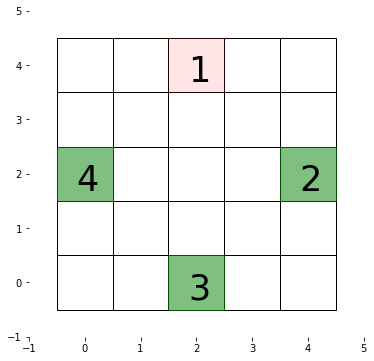

In [42]:
visualizeEnvironmentByState(states, [(2,0), (4,2), (0,2)],[(2,4)],[],{(2,4):'1', (4,2):'2', (2,0): '3',(0,2):'4'})